#### Importacion de librerias

In [2]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_12816/1320345935.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_btc[col].fillna(mean_value, inplace=True)


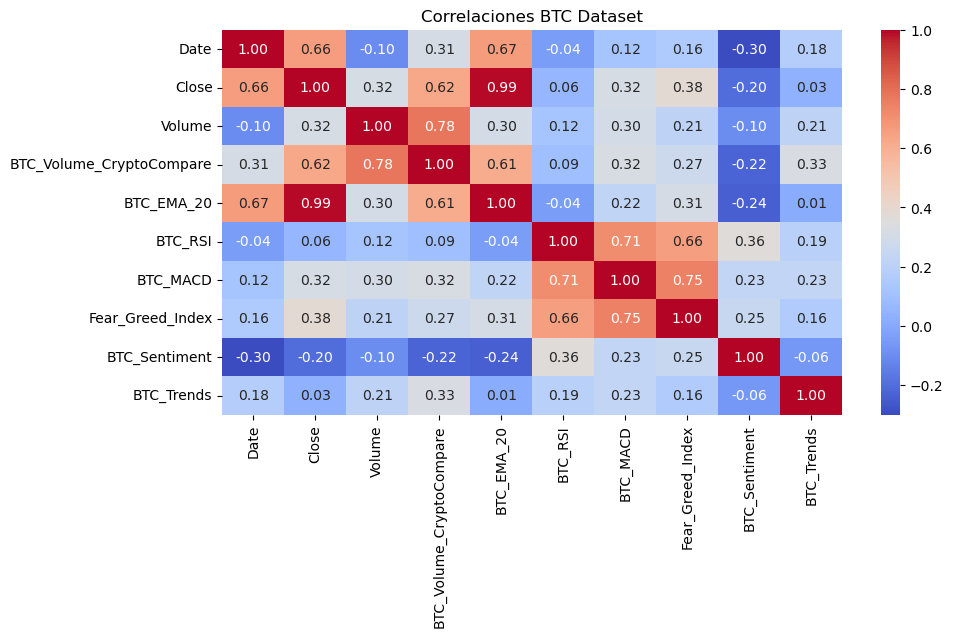

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


📊 Linear Regression - RMSE: 1981.2720970254106
📊 Random Forest - RMSE: 18330.106519938767
✅ Modelo guardado en Database/best_btc_model.pkl


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# 🔹 Cargar los datos
df_btc = pd.read_csv("Database/btc_final.csv")
df_eth = pd.read_csv("Database/eth_final.csv")

# 🔹 Convertir fechas a datetime
df_btc['Date'] = pd.to_datetime(df_btc['Date'])
df_eth['Date'] = pd.to_datetime(df_eth['Date'])

# 🔹 Imputación de valores faltantes
tech_indicators = ['BTC_EMA_20', 'BTC_RSI', 'BTC_MACD']  # Eliminamos BTC_SMA_50

# Obtener los primeros dos meses de datos
start_date = df_btc['Date'].min()
end_date = start_date + pd.DateOffset(months=2)
df_initial = df_btc[(df_btc['Date'] >= start_date) & (df_btc['Date'] < end_date)]

# Rellenar indicadores técnicos con el promedio de los primeros dos meses
for col in tech_indicators:
    mean_value = df_initial[col].mean()
    df_btc[col].fillna(mean_value, inplace=True)

# Rellenar Fear_Greed_Index con el promedio entre el valor anterior y el siguiente
df_btc['Fear_Greed_Index'] = df_btc['Fear_Greed_Index'].interpolate(method='linear')

# 🔹 Eliminar variables redundantes
df_btc.drop(columns=['BTC_SMA_50', 'BTC_Price_CryptoCompare', 'Open', 'High', 'Low'], inplace=True, errors='ignore')

# 🔹 Ver distribución de datos
plt.figure(figsize=(10, 5))
sns.heatmap(df_btc.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlaciones BTC Dataset")
plt.show()

# 🔹 Definir X y Y (Predecir el precio futuro)
df_btc['Target'] = df_btc['Close'].shift(-1)  # Precio del día siguiente
X = df_btc.drop(columns=['Date', 'Target'])  # Variables predictoras
Y = df_btc['Target'].dropna()  # Variable objetivo

# 🔹 Dividir en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X[:-1], Y, test_size=0.2, shuffle=False)

# 🔹 Entrenar modelos
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"📊 {name} - RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")

# 🔹 Guardar el mejor modelo
joblib.dump(models["Random Forest"], "Database/best_btc_model.pkl")
print("✅ Modelo guardado en Database/best_btc_model.pkl")

In [11]:
print(X_train.isna().sum())  # Ver cuántos NaN hay por columna
print(X_test.isna().sum())

Close                       0
Volume                      0
BTC_Volume_CryptoCompare    0
BTC_EMA_20                  0
BTC_RSI                     0
BTC_MACD                    0
Fear_Greed_Index            0
BTC_Sentiment               0
BTC_Trends                  0
dtype: int64
Close                       0
Volume                      0
BTC_Volume_CryptoCompare    0
BTC_EMA_20                  0
BTC_RSI                     0
BTC_MACD                    0
Fear_Greed_Index            0
BTC_Sentiment               0
BTC_Trends                  0
dtype: int64


#### Observaciones y Mejoras para el EDA (Exploratory Data Analysis)

In [12]:
# 🔹 Ver estadísticas descriptivas
print(df_btc.describe())

                                Date          Close        Volume  \
count                           1885    1885.000000  1.885000e+03   
mean   2022-07-31 00:00:00.000000256   38215.047584  3.366579e+10   
min              2020-01-01 00:00:00    4970.788086  5.331173e+09   
25%              2021-04-16 00:00:00   20041.738281  2.073473e+10   
50%              2022-07-31 00:00:00   33992.429688  3.020224e+10   
75%              2023-11-14 00:00:00   54824.117188  4.082689e+10   
max              2025-02-27 00:00:00  106146.265625  3.509679e+11   
std                              NaN   23375.860135  1.988304e+10   

       BTC_Volume_CryptoCompare     BTC_EMA_20      BTC_RSI     BTC_MACD  \
count              1.885000e+03    1885.000000  1885.000000  1885.000000   
mean               1.496036e+09   37793.682711    53.551067   334.559171   
min                8.598619e+07    6525.406505    14.034713 -5053.274080   
25%                5.721978e+08   20035.378067    43.843905  -510.265166  

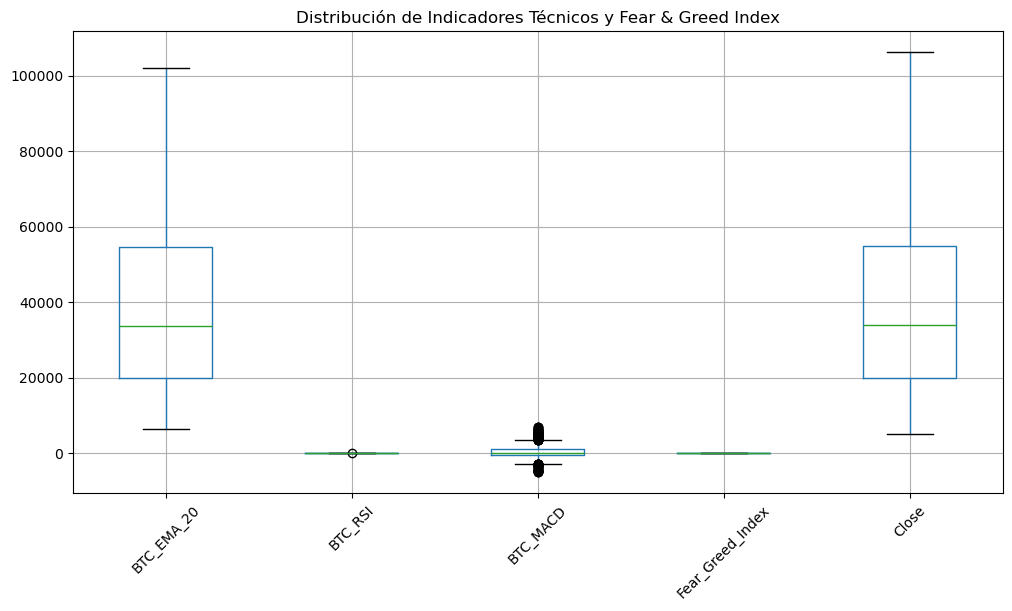

In [13]:
# 🔹 Visualizar outliers en indicadores clave
plt.figure(figsize=(12, 6))
df_btc[tech_indicators + ['Fear_Greed_Index', 'Close']].boxplot()
plt.xticks(rotation=45)
plt.title("Distribución de Indicadores Técnicos y Fear & Greed Index")
plt.show()

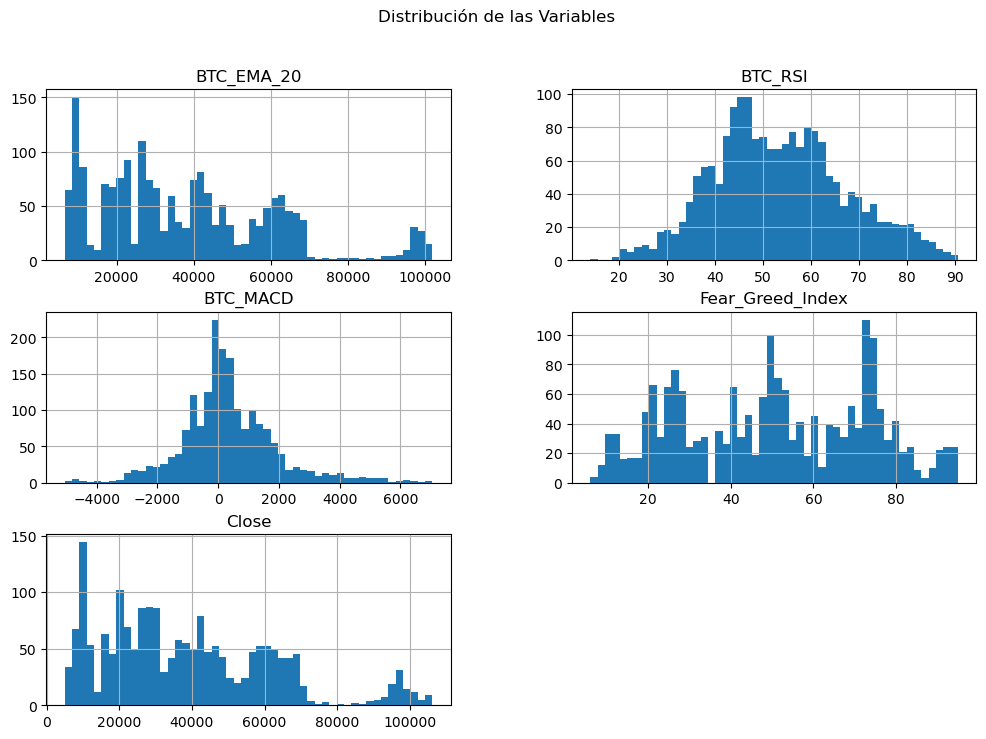

In [14]:
# 🔹 Histogramas de variables clave
df_btc[tech_indicators + ['Fear_Greed_Index', 'Close']].hist(figsize=(12, 8), bins=50)
plt.suptitle("Distribución de las Variables")
plt.show()

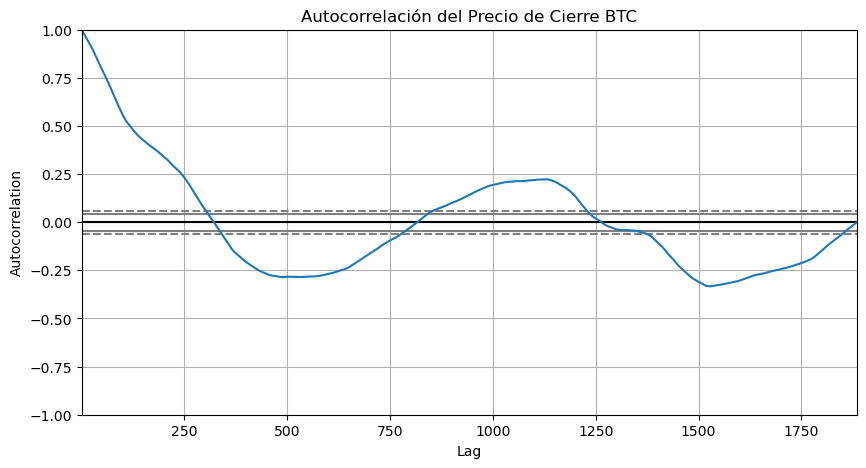

In [15]:
from pandas.plotting import autocorrelation_plot

# 🔹 Ver autocorrelación del precio de cierre
plt.figure(figsize=(10, 5))
autocorrelation_plot(df_btc['Close'].dropna())
plt.title("Autocorrelación del Precio de Cierre BTC")
plt.show()